# Определение возраста покупателей

<a id='description'></a>
## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения, которая будет обрабатывать фотографии покупателей в прикассовой зоне. С помощью фотофиксации и последующего анализа ее результатов будет определяться возраст клиентов.   

Магазину это необходимо для решения следующих задач:
* анализировать покупки клиентов, чтобы предлагать товары, которые могут заинтересовать конкретные возрастные группы покупателей;
* контролировать добросовестность кассиров при продаже алкоголя.

<a id='purpose'></a>
## Цель проекта

Необходимо построить модель, которая будет определять приблизительный возраст человека по его фотографии. В нашем распоряжении есть набор фотографий с разметкой по возрасту.

<a id='1'></a>
## Исследовательский анализ данных

In [8]:
#Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
#Загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [11]:
#Посмотрим основную информацию
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Найдено 7591 названий файлов, пропусков нет, типы данных корректные

In [12]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


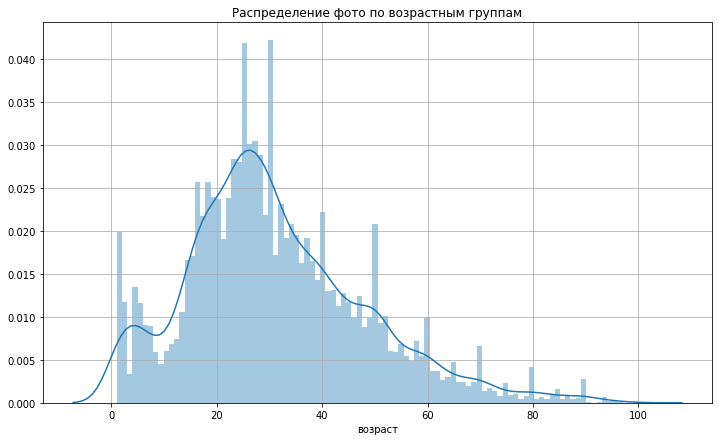

In [18]:
#Посмотрим на графике
plt.figure(figsize=(12,7))
sns.distplot(labels['real_age'], bins=100)
plt.title('Распределение фото по возрастным группам')
plt.xlabel('возраст')
plt.grid()

In [14]:
#Посмотрим описательную статистику по выборке
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [15]:
#Посмотрим топ-10 самых часто встречающихся в выборке возрастов
labels['real_age'].value_counts(ascending=False).head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

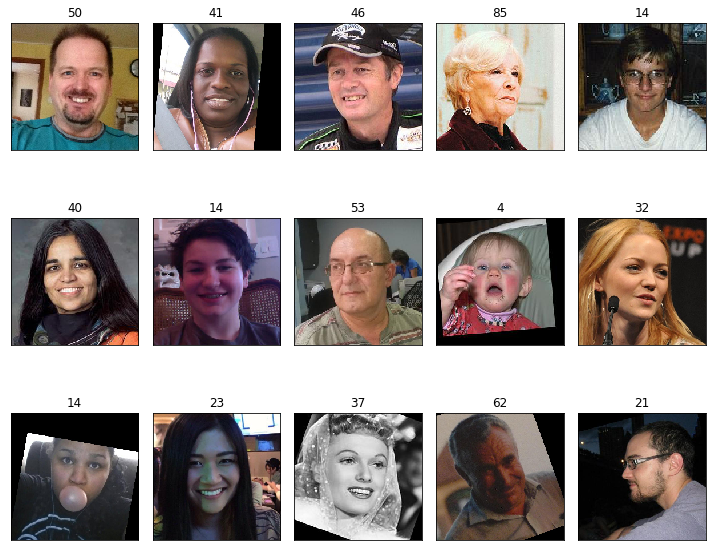

In [16]:
#Выведем 15 случайных фото
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<a id='1.1'></a>
### Вывод

Датасет содержит 7591 - это фотографии, промаркированные по возрастам объектов. Фото не упорядочены по возрасту и никак не сгруппированы.  

Большинство людей в выборке относятся к возрастной группе примерно от 20 до 30 лет. В то же время в выборке представлены все возраста - от младенцев до 100-летних.  

В датасете присутствуют фото разного качества, в том числе цветные, черно-белые, маленькие, повернутые, "пиксельные". Также люди на них представлены в разных положениях - анфас, вполоборота, с предметами, частично закрывающими лицо и т.п. То есть сет выглядит достаточно реалистично применительно к его потенциальному использованию - для анализа результатов фотофиксации у касс, где люди тоже могут принимать разные положения, и качество может получиться различным.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```

Found 6073 validated image filenames.
Found 1518 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 1121s - loss: 226.0806 - mae: 10.8767 - val_loss: 785.5697 - val_mae: 22.9678
Epoch 2/5
190/190 - 1103s - loss: 73.6397 - mae: 6.5372 - val_loss: 507.1110 - val_mae: 17.1255
Epoch 3/5
190/190 - 1102s - loss: 51.2553 - mae: 5.5038 - val_loss: 317.0154 - val_mae: 13.2464
Epoch 4/5
190/190 - 1108s - loss: 37.8848 - mae: 4.7051 - val_loss: 128.6443 - val_mae: 8.4494
Epoch 5/5
190/190 - 1105s - loss: 27.7175 - mae: 4.0213 - val_loss: 72.8298 - val_mae: 6.4975

48/48 - 53s - loss: 72.8298 - mae: 6.4975
Test MAE: 6.4975

```

## Анализ обученной модели

Для определения приблизительного возраста человека по фотографии была построена нейронная сеть с архитектурой ResNet и применением сверточных сетей, предобученых на ImageNet. Обучение модели проходит в 5 эпох с алгоритмом Adam, где learning_rate = 0.0001.

Итоговый результат метрики MAE на валидационной выборке - 6.4412. Это означает, что модель сможет определить возраст покупателя с точностью до 6,5 лет. Полученная цифра меньше заданного по ТЗ целевого значения, значит, результат на данном этапе нас устраивает.  

В целом, исходя из личного опыта, могу сказать, что возраст человека по внешности определить непросто (у каждого свои индивидуальные особенности, кто-то может выглядить моложе, кто-то - наборот). И поэтому погрешность в 5-7 вполне адекватна, человек в среднем может определять возраст примерно с такой же точностью.  

Применительно к целям проекта можно сделать следующие выводы:  

* Модель подходит для того, чтобы определять возрастную группу клиентов, которым можно предложить набор товаров, подобранный на основе предпочтений покупателей из той же группы. Целевые возрастные группы, скорее всего, будут охватывать порядка 7-10 лет, поэтому попадание модели будет хорошим. 
* Модель не идеально подходит для контроля добросовестности продавцов при продаже алкоголя. Так как, если учитывать погрешность, она в среднем сможет определить только совсем малолетних покупателей, но тех, кому 15-17 будет сложно отличить от 18-20 летних. Однако и человек визуально также не всегда сможет справиться с оценкой этих возрастных групп. Поэтому в целях контроля за продажей алкоголя имеет смысл выделить в системе некую "контрольную группу" (например, до 27 по оценке модели, чтоб с запасом). Эта группа будет считаться сомнительной, и кассир будет обязан проверять у нее документы, а система распознавания - контролировать этот процесс.
